In [1]:
# 1. 라이브러리 불러오기
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)

In [2]:
# 2. 전처리된 데이터 불러오기
X_train = pd.read_csv("../data/X_train.csv")
X_val = pd.read_csv("../data/X_val.csv")
X_test = pd.read_csv("../data/X_test.csv")
y_train = pd.read_csv("../data/y_train.csv").values.ravel()
y_val = pd.read_csv("../data/y_val.csv").values.ravel()
y_test = pd.read_csv("../data/y_test.csv").values.ravel()

In [3]:
# 3. 모델 정의
models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

results = {}

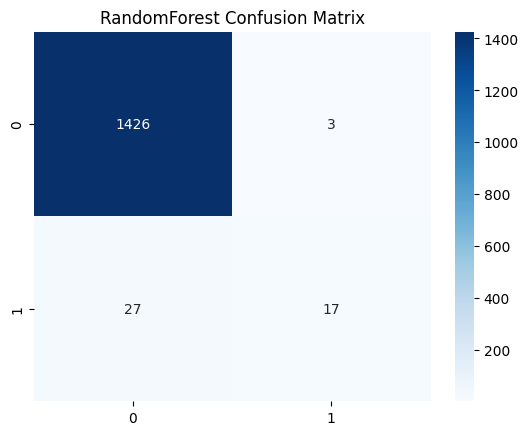

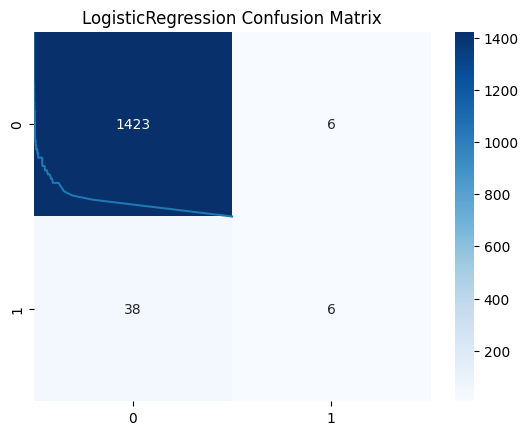

/opt/anaconda3/envs/smg/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:06:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


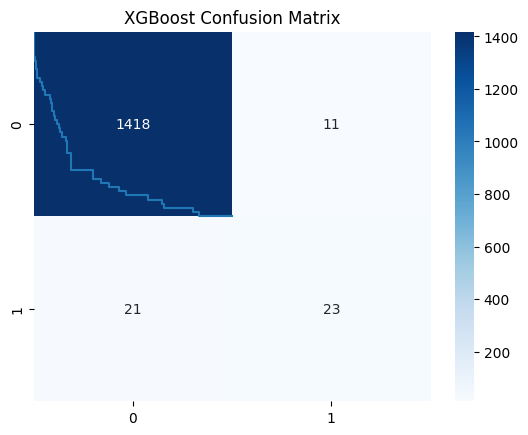

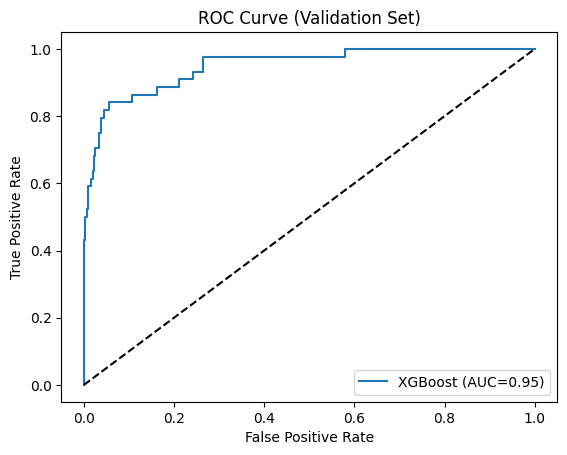

In [4]:
# 4. 학습 및 평가
for name, model in models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    # 성능 저장
    results[name] = {
        "accuracy": accuracy_score(y_val, y_pred),
        "precision": precision_score(y_val, y_pred),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
    }

    # Confusion Matrix 시각화
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation Set)")
plt.legend()
plt.show()

In [5]:
# 5. 결과 정리
pd.DataFrame(results).T

,accuracy,precision,recall,f1
RandomForest,0.979633,0.850000,0.386364,0.531250
LogisticRegression,0.970129,0.500000,0.136364,0.214286
XGBoost,0.978276,0.676471,0.522727,0.589744


In [ ]:
# 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

param_grid = {
    "n_estimators": [100, 200, 500],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
}

xgb = XGBClassifier(eval_metric="logloss", random_state=42)
grid = GridSearchCV(xgb, param_grid, cv=3, scoring="f1", n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

print("최적 하이퍼파라미터:", grid.best_params_)
best_model = grid.best_estimator_

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1

In [8]:
# 테스트 데이터 평가
from sklearn.metrics import classification_report

y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1430
           1       0.91      0.70      0.79        44

    accuracy                           0.99      1474
   macro avg       0.95      0.85      0.89      1474
weighted avg       0.99      0.99      0.99      1474



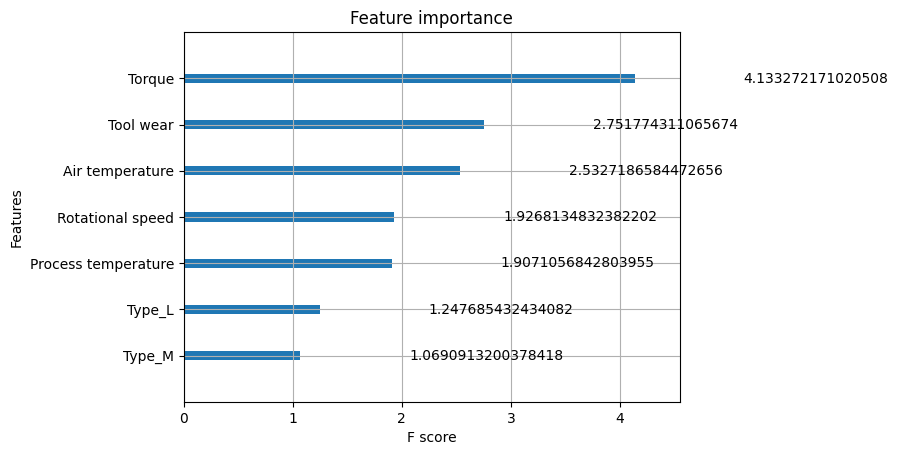

In [9]:
# Feature Importance 분석
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(best_model, importance_type="gain")
plt.show()


In [13]:
# 모델 저장
import joblib
joblib.dump(best_model, "xgb_final.pkl")

['xgb_final.pkl']